In [85]:
from img_cap_lib import *
# imports
import torch
import torchvision
import torchtext
from torchtext.vocab import vocab, GloVe, Vectors
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import os
from PIL import Image
import string
from collections import OrderedDict, Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import pickle
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import nltk

# Modellpfad festlegen

In [ ]:
model_path = "models/standart_model_with_normalisation.pt"

# Daten herunterladen

In [86]:
data_download("flickr8k")

flickr8k is not in the current directory
starting download...


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2285k  100 2285k    0     0  1060k      0  0:00:02  0:00:02 --:--:-- 2458k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1063M  100 1063M    0     0  3292k      0  0:05:30  0:05:30 --:--:-- 3067k


Archive:  captions.zip
  inflating: captions/CrowdFlowerAnnotations.txt  
  inflating: captions/ExpertAnnotations.txt  
  inflating: captions/Flickr8k.lemma.token.txt  
   creating: captions/__MACOSX/
  inflating: captions/__MACOSX/._Flickr8k.lemma.token.txt  
  inflating: captions/Flickr8k.token.txt  
  inflating: captions/Flickr_8k.devImages.txt  
  inflating: captions/Flickr_8k.testImages.txt  
  inflating: captions/Flickr_8k.trainImages.txt  
  inflating: captions/readme.txt     
Archive:  images.zip
   creating: images/Flicker8k_Dataset/
  inflating: images/Flicker8k_Dataset/1000268201_693b08cb0e.jpg  
   creating: images/__MACOSX/
   creating: images/__MACOSX/Flicker8k_Dataset/
  inflating: images/__MACOSX/Flicker8k_Dataset/._1000268201_693b08cb0e.jpg  
  inflating: images/Flicker8k_Dataset/1001773457_577c3a7d70.jpg  
  inflating: images/__MACOSX/Flicker8k_Dataset/._1001773457_577c3a7d70.jpg  
  inflating: images/Flicker8k_Dataset/1002674143_1b742ab4b8.jpg  
  inflating: images/_

mv: rename images/Flickr8k_Dataset to flickr8k/images: No such file or directory


download complete


# Modell mit Normalisierung

## Modell laden

In [102]:
# load model
model_stats = torch.load(model_path, map_location=torch.device('cpu'))
model = load_captioning_model(model_stats)

## Preprocessing

In [103]:
# caption preprocessing
embedding_dim = 300
min_frequency = 1

captions = pd.read_csv("flickr8k/captions.txt")
caption_preprocessor = CaptionPreprocessor(embedding=model_stats['embedding'].embedding_matrix, vocabulary=model_stats['embedding'].vocabulary ,captions=captions, embedding_dim=embedding_dim, min_frequency=min_frequency)
caption_preprocessor.preprocess()

# image preprocessing
img_preprocessor = ImagePreprocessor(normalize=True, image_folder_path="flickr8k")
img_preprocessor.preprocess_images()

Shape captions: (40460, 2)
Shape captions after filtering: (39749, 3)
Removed Captions:  711 , in Percent:  1.76


/Users/ronnyschneeberger/Documents/FHNW/HS22/del-image-captioning/img_cap_lib.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.captions.caption = self.captions.caption.apply(lambda x: x.strip("."))


transformed_images folder already exists. No preprocessing necessary.


## Datensplit und DataLoader

In [104]:
# create split
training_data, test_data = train_test_split(caption_preprocessor.captions, test_size=0.15, random_state=42)

# create datasets
train_dataset = FlickrDataset(captions=training_data, embedding=model.embedding)
test_dataset = FlickrDataset(captions=test_data, embedding=model.embedding)

# create dataloaders
batch_size = 8
train_loader = FlickrLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = FlickrLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [158]:
def visualize_model_results(model, df:pd.DataFrame, n_samples=8):
    sample = df.sample(n_samples)

    for i, image_path in enumerate(sample.image.values):
        input = torchvision.io.read_image("flickr8k/transformed_images/" + image_path).float()
        image = Image.open("flickr8k/images/" + image_path)
        plt.imshow(image)
        plt.show()
        print("predicted")
        predicted_caption = model.forward(input.unsqueeze(0))
        predicted_caption = " ".join(predicted_caption)
        predicted_caption = predicted_caption.split('<EOS>')[0]
        predicted_caption = predicted_caption.lstrip('<SOS>')
        print(20*"-")
        print(predicted_caption + "\n")
        print("caption")
        print(20*"-")
        caption = sample["caption"].iloc[i]
        caption = " ".join(eval(caption))
        caption = caption.split('<EOS>')[0]
        caption = caption.lstrip('<SOS>')
        print(caption + "\n")

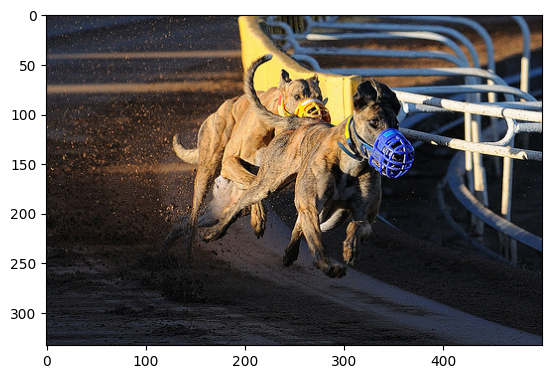

predicted
--------------------
 two racing dogs run around a track 

caption
--------------------
 two racing dogs run around a track 



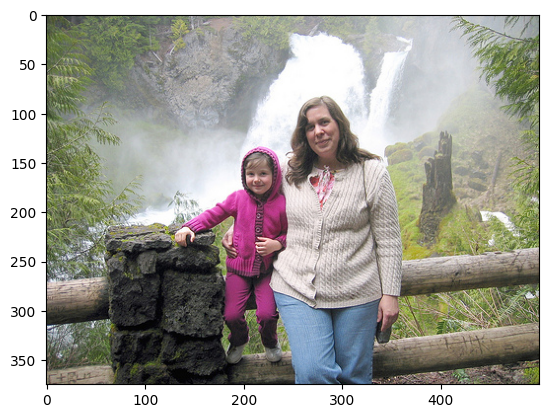

predicted
--------------------
 a woman and a child are sitting on a log and stone stone buildings 

caption
--------------------
 a woman and her daughter in front of a waterfall 



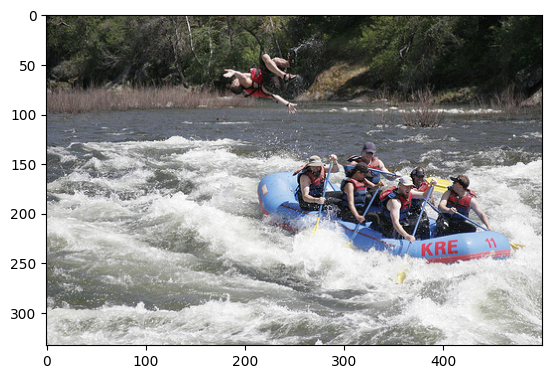

predicted
--------------------
 the six people are in a blue raft in the water and one person flew out of the raft 

caption
--------------------
 a person flies backward off a blue raft near rapids 



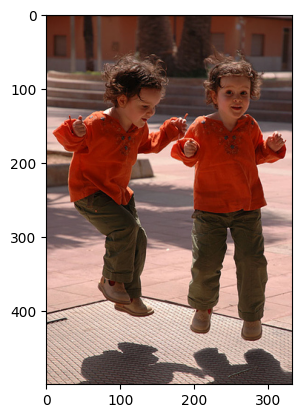

predicted
--------------------
 two young twin girls in matching green and orange outfits jump in the air 

caption
--------------------
 twins in orange shirts jumping on a trampoline 



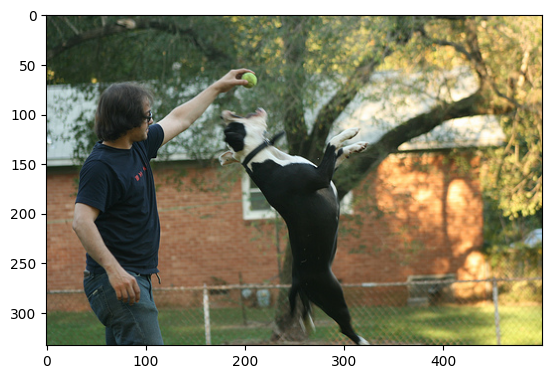

predicted
--------------------
 man with dog who is jumping with a ball 

caption
--------------------
 a man wearing glasses and his black and white dog wearing a black collar are playing with a tennis ball 



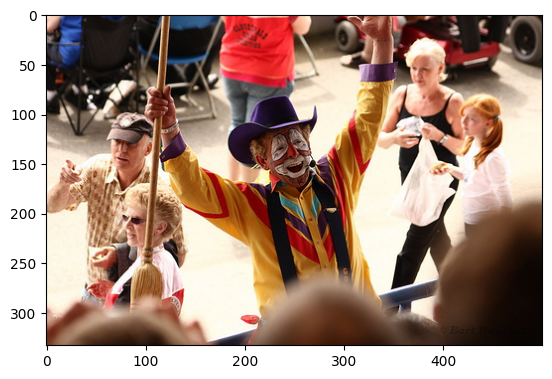

predicted
--------------------
 a clown in a colorful shirt is on an outdoor court 

caption
--------------------
 a clown in a colorful shirt and cowboy hat is raising his arms in a crowd of people 



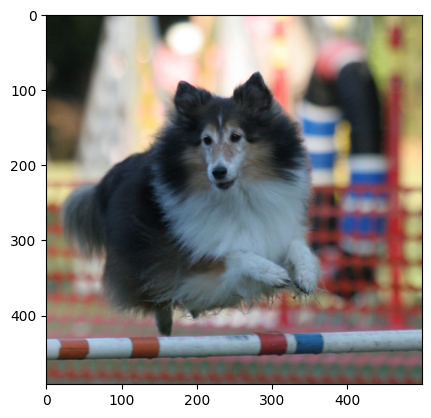

predicted
--------------------
 a dog jumping over a hurdle 

caption
--------------------
 a dog jumps over a barrier 



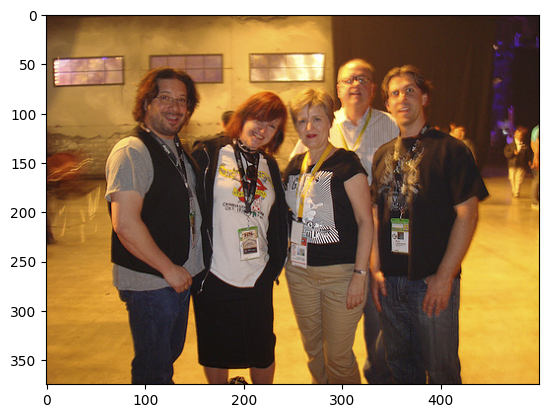

predicted
--------------------
 five people are standing in front of an industrial style building posing for a man 

caption
--------------------
 five people are standing in front of an industrial style building posing for a photograph 



In [161]:
visualize_model_results(model, training_data)

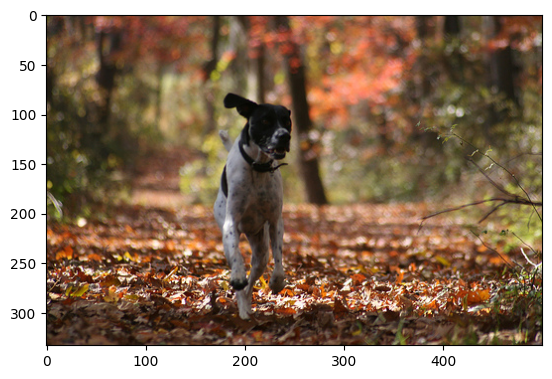

predicted
--------------------
 a dog with a large orange ball in its mouth is doing in front of a crowd of spectators 

caption
--------------------
 a white and brown dog is running over orange leaves 



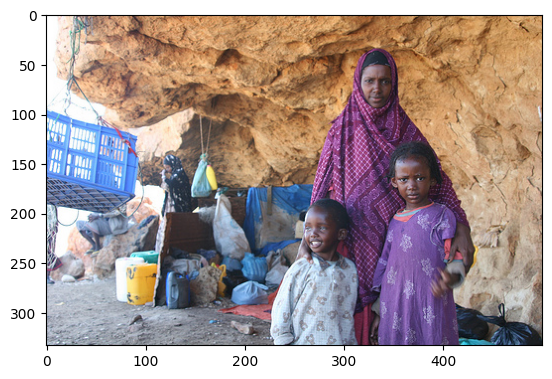

predicted
--------------------
 an african woman stands with her two children under a boulder 

caption
--------------------
 a woman and two children pose for a picture under some rocks 



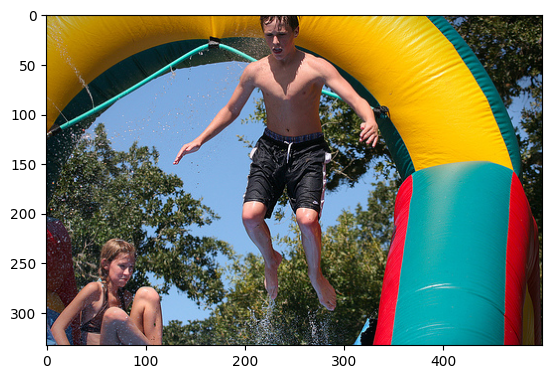

predicted
--------------------
 a young boy jumping and a young girl seating in an inflatable pool 

caption
--------------------
 a boy is jumping on an inflatable ring and a girl is watching him 



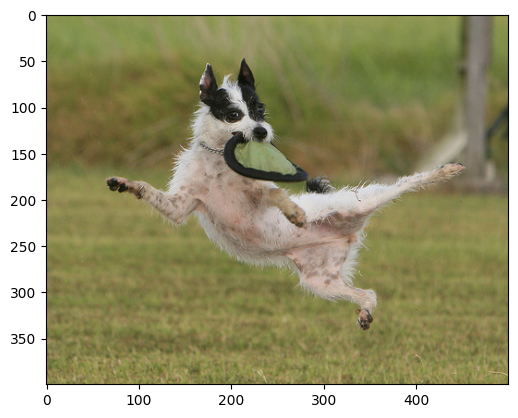

predicted
--------------------
 a dog catching a frisbee 

caption
--------------------
 small dog jumps sideways to catch a soft disc 



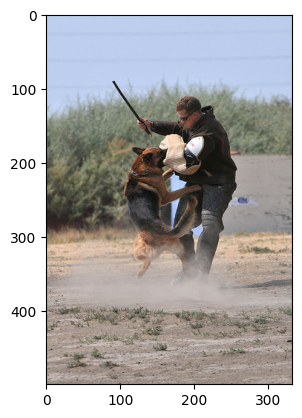

predicted
--------------------
 a german shepherd bites the arm of a man who has on protective gear 

caption
--------------------
 a dog attacking a man wearing protective gear 



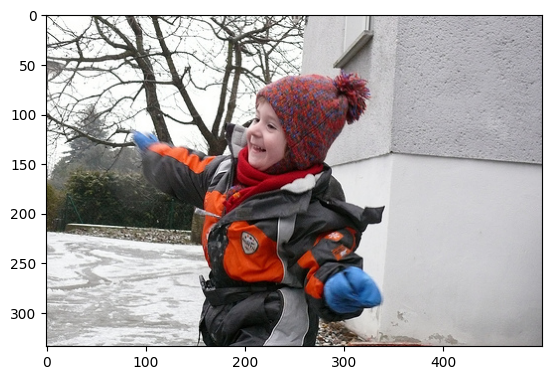

predicted
--------------------
 a smiling boy in winter clothes waves his mittened hands outside a building in the snow 

caption
--------------------
 a baby in winter clothes plays outside 



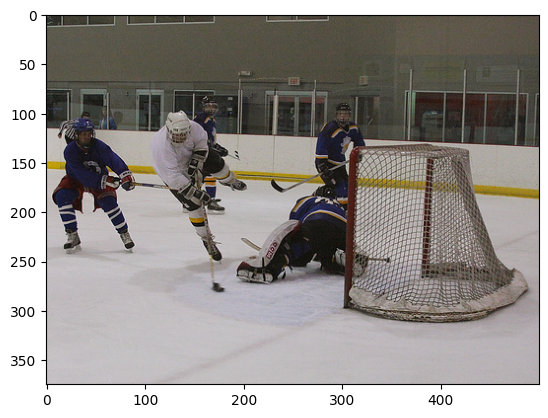

predicted
--------------------
 a group of hockey players slide along the ice during a game 

caption
--------------------
 two hockey player teams playing a game on the ice 



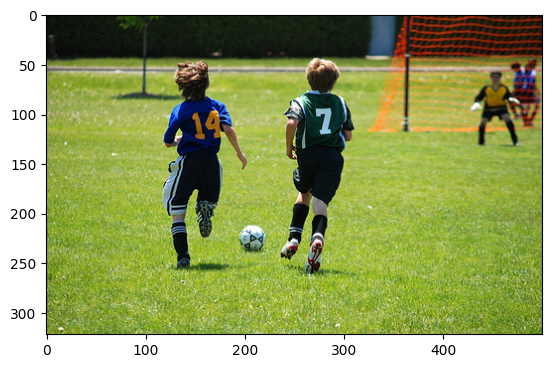

predicted
--------------------
 two boys run after a soccer ball during a game 

caption
--------------------
 two opposing soccer players run toward the ball while a goalies prepares a block 



In [160]:
visualize_model_results(model, test_data)